In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from torch.nn import Module, Linear, MSELoss
from torch.optim import Adam
import torch
from sklearn.svm import OneClassSVM

from sklearn.neighbors import LocalOutlierFactor
from torch.utils.data import DataLoader
import visualizing_utils as viz
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv('OD_dataset.csv')  
data_sliced = data.loc[:, list(data)[1:]]
names = data.loc[:,list(data)[0]]
df = (data_sliced - data_sliced.mean())/data_sliced.std() #data normalization

<h2>1. Exploratory data analysis</h2>
<ol>
    <li>Basic information about the data</li>
    <li>Correlation of features</li>
    <li>Histograms of features</li>
</ol>


Remarks:
<ul>
    <li>During the preprocessing highly correlated features will be dropped (covariance of normalized features > 0.8) - getting rid of redundant dimensions is particularly important for PAM clustering. High dimensionality increases the sparsity of data, so that the distances between "normal" data might be big, which may downgrade the quality of created model.</li>
</ul>

In [3]:
df.describe()

,tx_cnt,amt_mean,amt_median,amt_std,amt_skew,amt_kurt,amt_q025,amt_q05,amt_q95,amt_q975,...,vol_chg_q2,vol_chg_q3,vol_chg_q4,ref_pct,ref_vol_pct,vel_purch_cnt,vel_purch_vol,vel_ref_cnt,vel_ref_vol,num_outlets
count,2.680000e+02,268.000000,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,...,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02,2.680000e+02
mean,2.651279e-17,0.000000,2.651279e-16,1.259357e-16,-5.269417e-16,8.285246e-18,-7.556145e-16,-7.158453e-16,9.279476e-17,1.590767e-16,...,-6.628197e-18,1.325639e-17,-1.657049e-17,-1.325639e-17,-1.325639e-17,6.628197e-18,-2.054741e-16,-3.645508e-17,3.314099e-17,6.628197e-18
std,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.649432e-01,-0.525964,-8.419566e-01,-3.027041e-01,-5.583675e-01,-1.866129e-01,-1.078316e+00,-1.124762e+00,-3.698104e-01,-3.353169e-01,...,-8.681408e-01,-6.238516e-02,-7.985609e-02,-7.680613e-02,-6.508316e-02,-1.959960e-01,-2.244482e-01,-8.038617e-02,-7.660399e-02,-1.200669e-01
25%,-1.565660e-01,-0.308120,-4.277070e-01,-2.384845e-01,-4.103529e-01,-1.839740e-01,-4.294608e-01,-4.768385e-01,-2.514880e-01,-2.399730e-01,...,-8.730817e-02,-6.235224e-02,-7.080755e-02,-7.680613e-02,-6.508316e-02,-1.737091e-01,-2.024749e-01,-8.038617e-02,-7.660399e-02,-1.200669e-01
50%,-1.318475e-01,-0.268511,-3.229240e-01,-2.218929e-01,-3.066545e-01,-1.735467e-01,-3.027077e-01,-2.195299e-01,-2.194694e-01,-2.172060e-01,...,-7.728178e-02,-6.235067e-02,-7.014637e-02,-7.680613e-02,-6.508316e-02,-1.499835e-01,-1.846040e-01,-8.038617e-02,-7.660399e-02,-1.200669e-01
75%,-9.595919e-02,-0.129768,-1.206815e-01,-1.412966e-01,1.035700e-02,-1.315886e-01,8.139122e-03,-8.810931e-02,-1.146319e-01,-1.201885e-01,...,-2.889888e-02,-6.234741e-02,-6.484436e-02,-7.680613e-02,-6.508316e-02,-1.094524e-01,-1.395871e-01,-8.038617e-02,-7.660399e-02,-1.095787e-01
max,1.249179e+01,9.109497,6.573976e+00,1.161292e+01,1.057759e+01,1.104833e+01,8.316502e+00,7.151643e+00,1.040953e+01,1.002592e+01,...,1.578518e+01,1.630824e+01,1.624024e+01,1.570552e+01,1.628478e+01,1.236350e+01,1.361108e+01,1.610263e+01,1.617139e+01,1.538505e+01


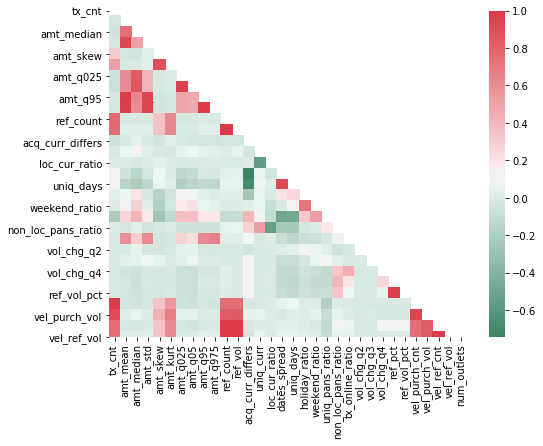

In [4]:
cova = df.cov()
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(150, 10, as_cmap=True)
mask = np.triu(np.ones_like(cova, dtype=np.bool))
sns.heatmap(cova, mask = mask, cmap = cmap)

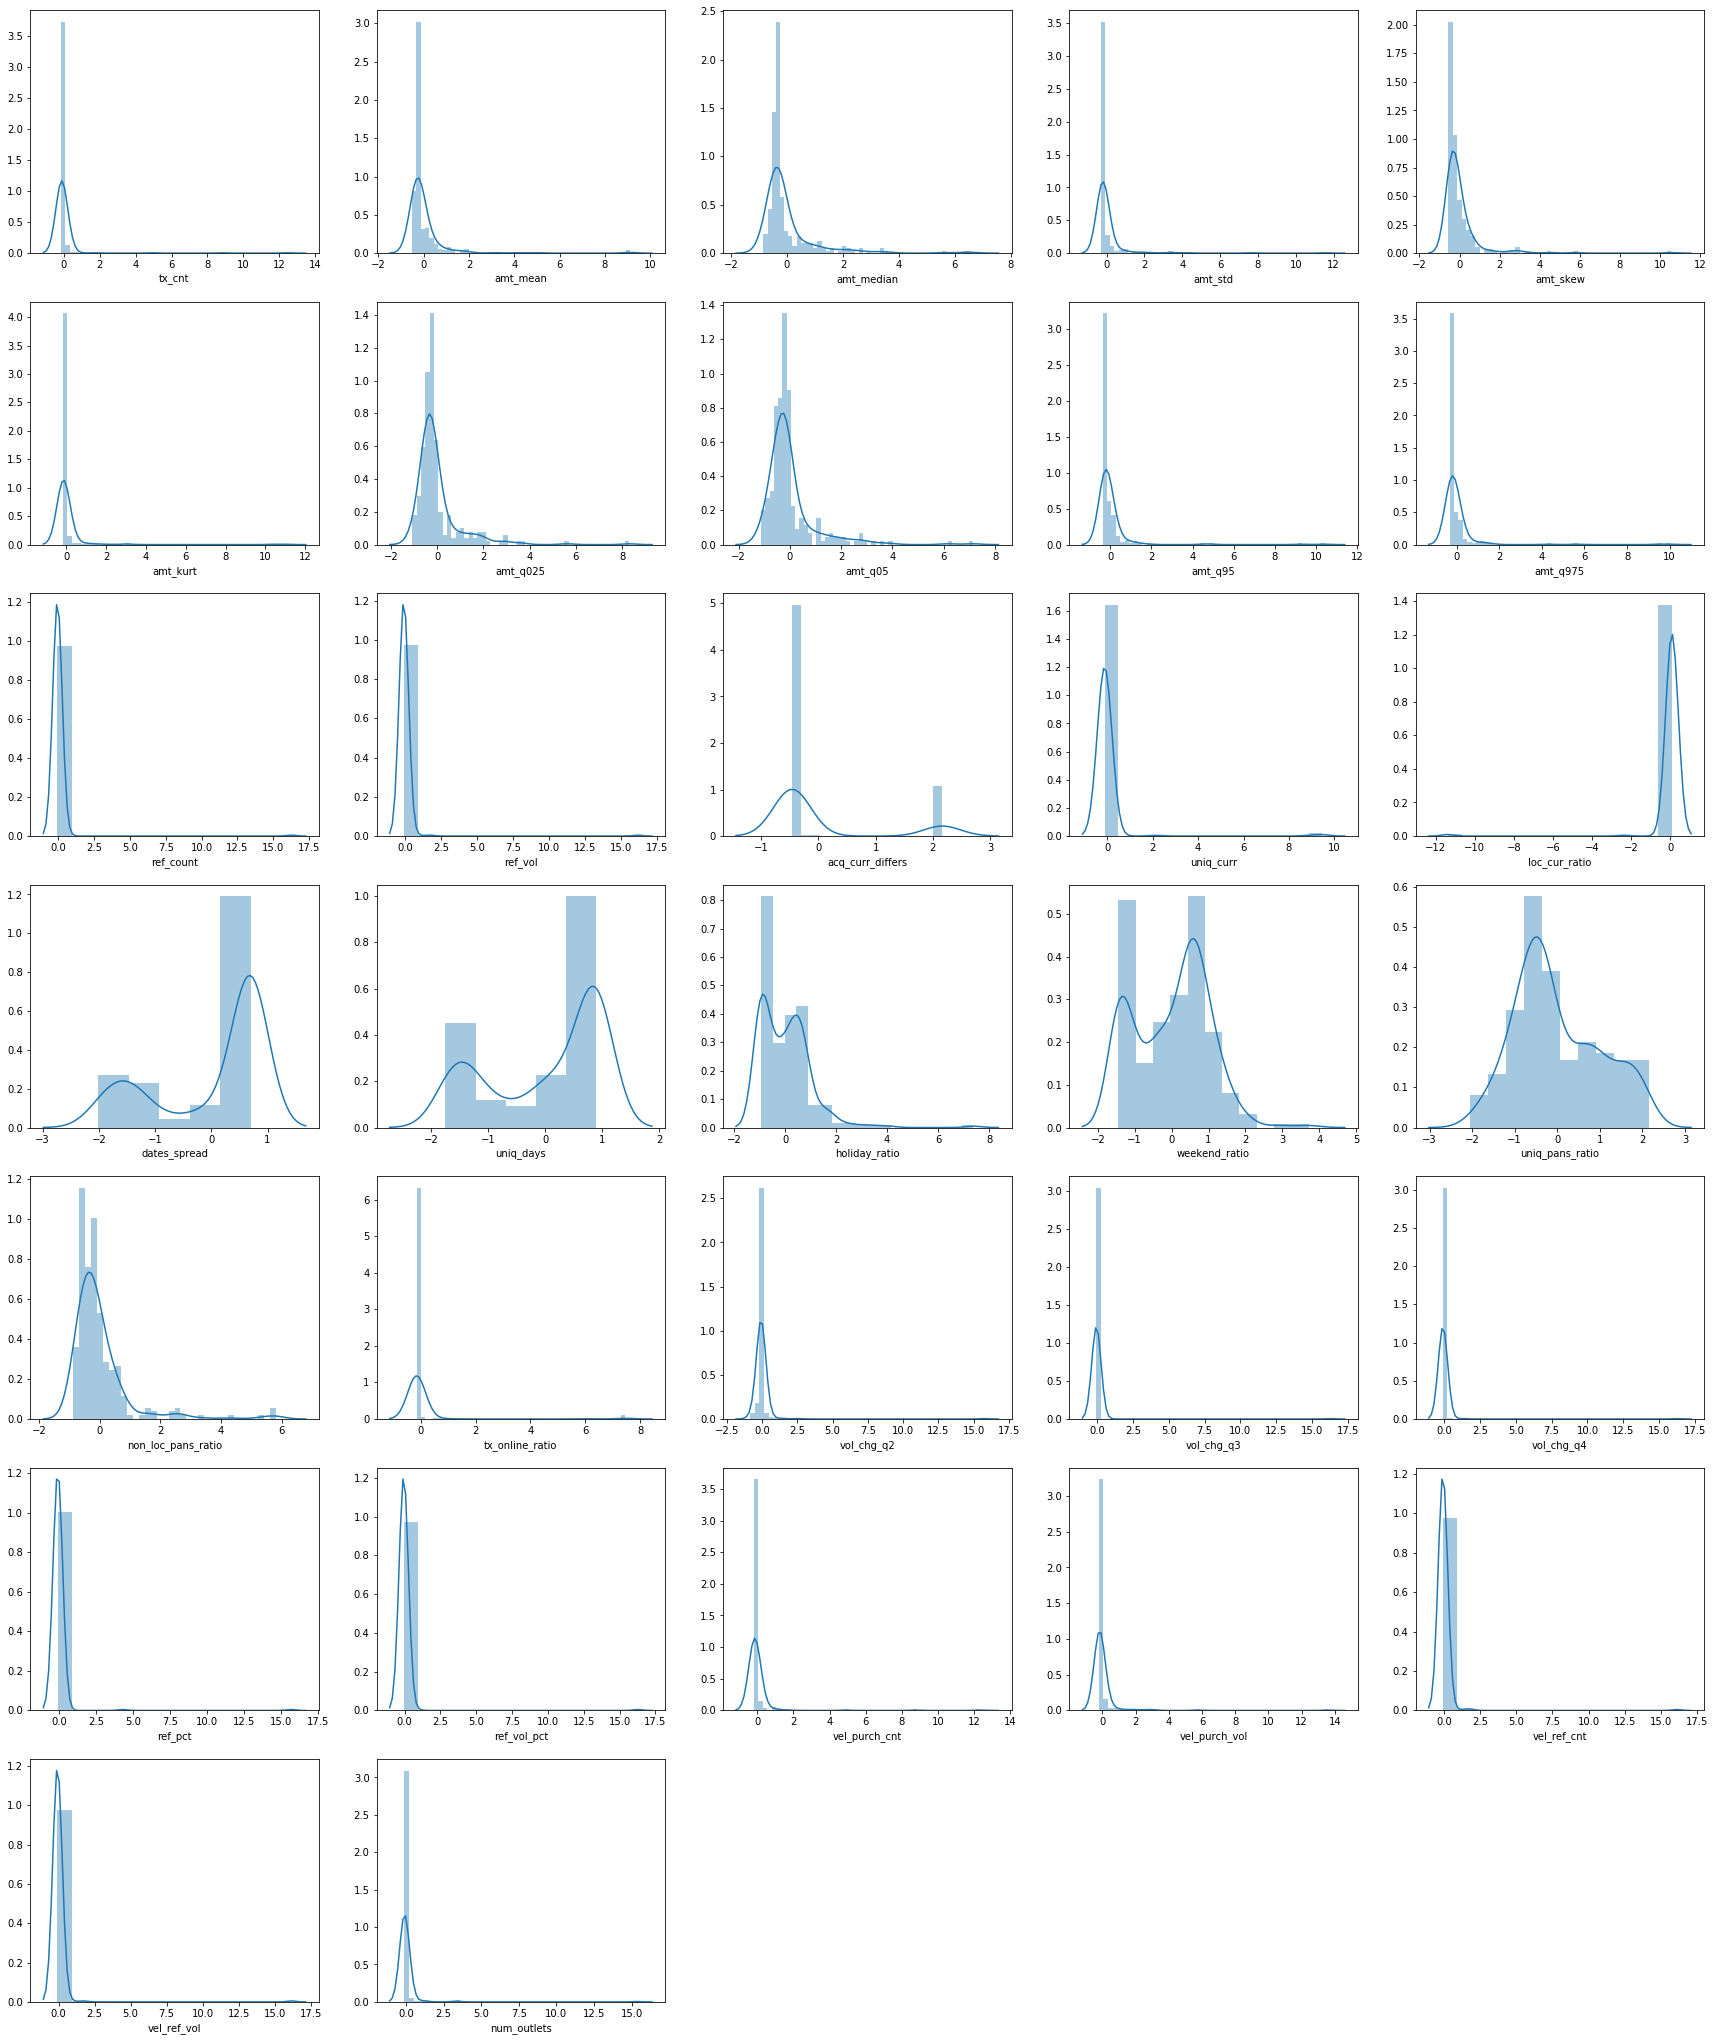

In [5]:
l = df.columns.values
rows = 7
columns = 5
plt.figure(figsize=(6*columns, 6*rows))
for i in range(0,len(l)):
    plt.subplot(rows+1,columns,i+1)
    sns.distplot(df[l[i]],kde=True) 

In [6]:
#drop highly correlated features

column_names = list(df)
length = len(column_names)
deleted = []
for i in range(0,length):
    col = column_names[i]
    if col in deleted:
        continue
    x_cor = abs(cova[col])
    correlated_features = list(x_cor[x_cor>0.8].to_frame().index)
    correlated_features.remove(col)
    
    for y in correlated_features:
        deleted.append(y)
        df = df.drop(y, axis=1)
    cova = df.cov()

In [7]:
print(df.shape)
df.head()

(268, 19)


,tx_cnt,amt_mean,amt_median,amt_skew,ref_count,acq_curr_differs,uniq_curr,loc_cur_ratio,dates_spread,holiday_ratio,weekend_ratio,uniq_pans_ratio,non_loc_pans_ratio,tx_online_ratio,vol_chg_q2,vol_chg_q3,vol_chg_q4,ref_pct,num_outlets
0,-0.150877,-0.294056,-0.363485,-0.354568,-0.070236,-0.463149,-0.113659,0.095295,-0.985185,0.428037,0.217411,-0.559134,-0.537313,-0.150336,-0.077282,-0.061712,-0.067817,-0.076806,-0.120067
1,0.036474,-0.257077,-0.443856,-0.411895,-0.070236,-0.463149,-0.113659,0.095295,0.700005,0.538036,0.359096,-0.231799,-0.080928,-0.149376,-0.077898,-0.062350,-0.072306,-0.076806,-0.050145
2,-0.158352,1.189511,2.623018,-0.457288,-0.070236,-0.463149,-0.113659,0.095295,-1.464308,0.230863,1.096956,1.520790,0.396958,-0.146498,-0.077282,-0.062351,-0.064844,-0.076806,-0.116571
3,-0.162616,-0.293298,-0.407802,-0.154390,-0.070236,-0.463149,-0.113659,0.095295,0.700005,-0.484929,-0.882597,-0.251878,0.114633,-0.151511,-0.394992,-0.062361,-0.071035,-0.076806,-0.113075
4,-0.164941,0.051412,0.816544,-0.558368,-0.070236,-0.463149,-0.113659,0.095295,-0.059983,7.385958,3.713345,2.166009,-0.881128,-0.151511,-0.077282,-0.062188,-0.064844,-0.076806,-0.106083


<h2>2.Finding outliers</h2>
<ol>
    <li>PAM Clustering</li>
    <li>Reconstruction error of autoencoder</li>
</ol>

Simplifying assumptions:
<ul>
    <li>the objective is to detect outliers in the provided dataset, not to create a robust model that will generalize well, therefore considering the small size of dataset, divison of dataset into train and validation will be neglected. Models will be trained on all provided data</li>
    <li>since we know the percentage of outliers in the dataset, the number of seeked outliers will be fixed and set to 5 (preference for false positives among outliers, that can be analysed manually in further steps of analysis) </li>
</ul>

<h3>2.1 PAM Clustering</h3>
PAM Clustering algorithm was chosen for anomaly detection due to its good robustness towards outliers among the ones belonging to k-centers algorithms. The number of clusters will be chosen corresponding to the internal evaulation criterion - silhouette width. The clustering maximizing silhouette width will be applied [1].

Outliers will be chosen as elements that have maximum distance to the closest medoid.





In [12]:
num_clusters = 10


for x in range(2,num_clusters):
    km = KMedoids(n_clusters=x)
    kmeans = km.fit(df)
    centroids = kmeans.cluster_centers_
    y_kmeans = kmeans.predict(df)
    silhouette_avg = silhouette_score(df, y_kmeans)
    print(f"Number of clusters {x}, avg silh: {silhouette_avg}")


Number of clusters 2, avg silh: 0.17251634514962555
Number of clusters 3, avg silh: -0.024864590714183333
Number of clusters 4, avg silh: 0.1635242056529558
Number of clusters 5, avg silh: 0.1317204752927541
Number of clusters 6, avg silh: 0.1190423674834056
Number of clusters 7, avg silh: 0.05568794717264774
Number of clusters 8, avg silh: 0.06582268050260962
Number of clusters 9, avg silh: 0.04173094418505561


In [13]:
km = KMedoids(n_clusters=2)
kmeans = km.fit(df)

In [14]:
outliers_indices = np.argsort(kmeans.transform(df).min(axis=1))[-5:]

In [15]:
print("Outliers found:")
print(names[outliers_indices].values)

Outliers found:
['EID-2196' 'EID-865004798' 'EID-6532' 'EID-6558' 'EID-1270']


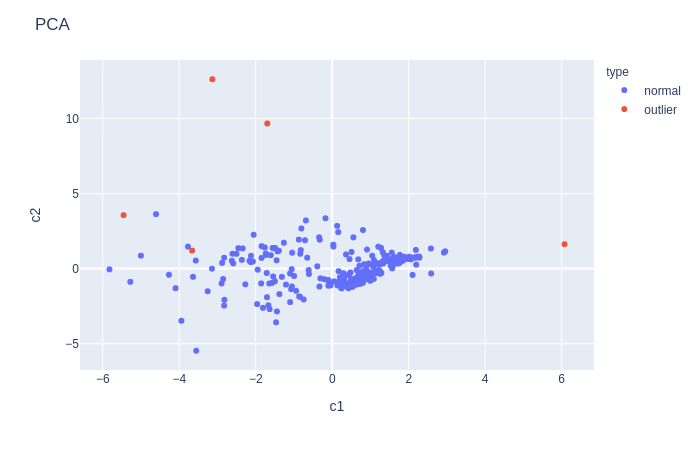

In [44]:
viz.show_pca(df, outliers_indices, names)

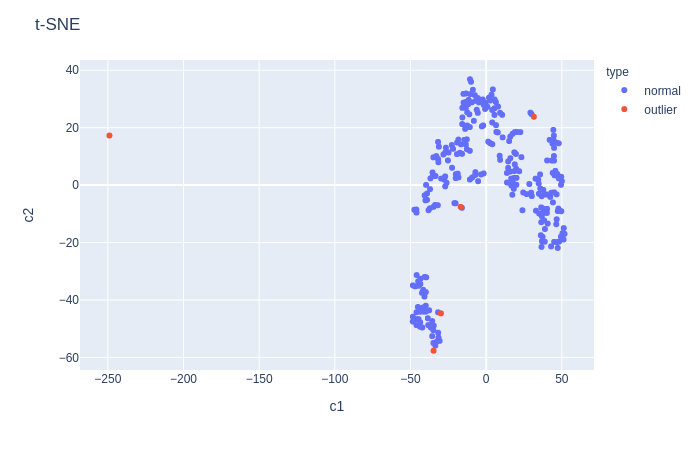

In [45]:
viz.show_tsne(df, outliers_indices, names)

<h3>2.2 Reconstruction error of autoencoder</h3>
Our dataset contains only around 1% of outliers, therefore it is expected, that autoencoder is able to learn  reconstructing well the "normal" examples, whereas outliers should produce higher reconstruction error (little data, so the autoencoder will not learn how to reconstruct outliers)[2].

Outliers will be chosen as elements that have maximal reconstruction error.


Assumptions:
The number of neurons in autoencoder's "bottleneck" was set to 4 and batch size to 16.




In [19]:
input_neurons = 19
hidden_neurons = 4
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.fc1 = Linear(input_neurons, hidden_neurons)
        self.fc2 = Linear(hidden_neurons, hidden_neurons)
        self.fc3 = Linear(hidden_neurons, input_neurons)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
model = AutoEncoder()
criterion = MSELoss()
optimizer = Adam(model.parameters())

In [20]:
batch_size = 16
num_iters = 250
data_tensor = torch.tensor(df.values.astype(np.float32))
train_loader = DataLoader(data_tensor, batch_size=batch_size,shuffle=True, num_workers=0)



In [21]:
def train():
    ls = []
    for batch_i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        ls.append(loss.item()/batch_size)
    return np.mean(ls)

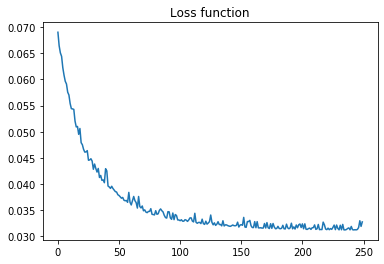

In [22]:
losses=[]
for epoch in range(num_iters):
    losses.append(train())
    

plt.plot(np.arange(num_iters),losses)
plt.title("Loss function")
plt.show()

In [23]:
test_loader = DataLoader(data_tensor, batch_size=1,shuffle=False, num_workers=0)

errors = []
with torch.no_grad():
    for batch_i, batch in enumerate(test_loader):
        out = model(batch)
        err = criterion(out, batch)
        errors.append(err.item())

In [24]:
outliers_indices_ae = np.argsort(errors)[-5:]

In [26]:
print("Outliers found:")
print(names[outliers_indices_ae].values)

Outliers found:
['EID-6532' 'EID-6558' 'EID-2071' 'EID-390' 'EID-865004798']


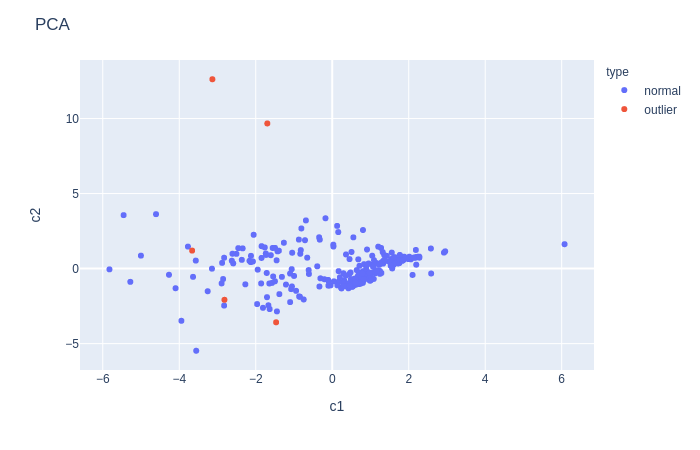

In [42]:
viz.show_pca(df, outliers_indices_ae, names)

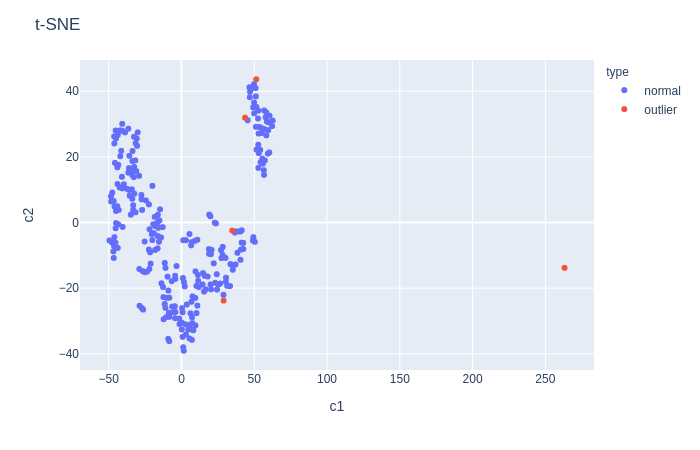

In [46]:
viz.show_tsne(df, outliers_indices_ae, names)


<h3>3.Evaluation of results and conclusions </h3>

<ul>
       <li>Validation of obtained results can be done be using intrinsic measures, such as local density around a suspicious point </li>
       <li>Ensembling different methods might help improve efficiency and increase the certanity about made predictions </li>
       <li>Expert knowledge might be needed to check manually the outliers </li>
    <li>Plotting data of reduced dimensionality does not neccessairly provide valuable insight into the data. The dimensions indicating on anomaly might be "dropped" by dimensionality reduction techniques</li>
</ul>


In [47]:
print("Elements classified by both methods as outliers:")
print(set(names[outliers_indices_ae].values).intersection(names[outliers_indices].values))


Elements classified by both methods as outliers:
{'EID-6532', 'EID-6558', 'EID-865004798'}


<h2>Sources</h2>
[1] Paweł Cichosz. „Anomaly detection in discussion forum posts using glo-bal vectors”. W:Photonics Applications in Astronomy, Communications,Industry, and High-Energy Physics Experiments 2018. T. 10808. Interna-tional Society for Optics i Photonics. 2018, 108081R.

[2] Varun Chandola, Arindam Banerjee i Vipin Kumar. „Anomaly Detection:A Survey”. W:ACM Comput. Surv.41.3 (lip. 2009).issn: 0360-0300.doi:10.1145/1541880.1541882.url:https://doi.org/10.1145/1541880.1541882.